# CAPSTONE PROJECT

### 1. import libraries

In [14]:
#!conda install -c conda-forge wordcloud==1.4.1 --yes
import numpy as np
import pandas as pd
import requests
import random
from sklearn.cluster import KMeans
from pandas.io.json import json_normalize
import folium
from folium.plugins import MiniMap
from geopy.geocoders import Nominatim
import json
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn import metrics
from PIL import Image
import matplotlib.patches as mpatches
from wordcloud import WordCloud, get_single_color_func
print('Libraries imported.')

Libraries imported.


### 2. Loading Neighbourhood data in New York and Toronto
<li>New York:     <a>https://ibm.box.com/shared/static/fbpwbovar7lf8p5sgddm06cgipa2rxpe.json</a></li>
<li>Toronto:     <a>https://ibm.box.com/shared/static/fbpwbovar7lf8p5sgddm06cgipa2rxpe.json</a></li>

#### 2.1 Download New York Data and set it up into a pandas dataframe

In [15]:
# Getting New York data

with open('nyu_2451_34572-geojson.json') as json_data:
    newyork_data = json.load(json_data)
    
print('\n...data loaded succesfully!')

neighborhoods_ny = pd.DataFrame(columns = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'])
for data in newyork_data['features']:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods_ny = neighborhoods_ny.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

#Take only neighborhoods from manhattan!
neighborhoods_ny = neighborhoods_ny[neighborhoods_ny['Borough'] == 'Manhattan'].reset_index(drop=True)
neighborhoods_ny.head()


...data loaded succesfully!


,Borough,Neighborhood,Latitude,Longitude
0,Manhattan,Marble Hill,40.876551,-73.910660
1,Manhattan,Chinatown,40.715618,-73.994279
2,Manhattan,Washington Heights,40.851903,-73.936900
3,Manhattan,Inwood,40.867684,-73.921210
4,Manhattan,Hamilton Heights,40.823604,-73.949688


In [16]:
print("Neighborhoods in New York city: {}.".format(neighborhoods_ny.shape[0]))

Neighborhoods in New York city: 40.


#### 2.2 Download Toronto Data and set it up into a pandas dataframe

In [33]:
webPage = requests.get("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M")
html = webPage.text                                                                       
tableInit = html.find('<table class="wikitable sortable">')                            
tableFinal = html.find('</table>')                                                      
htmlTable = html[tableInit:tableFinal]
print('\n...data loaded succesfully!')
table = pd.read_html(htmlTable, header = 0)[0]                                            
table["Borough"] = table["Borough"].replace({"Not assigned":np.nan})                
table.dropna(inplace = True)                                                          
table.where(table != "Not assigned", table["Borough"], axis = 0, inplace = True)      
joinedRows = table.groupby("Postcode")["Neighbourhood"].apply(lambda x: ", ".join(x)) 
table.drop_duplicates(["Postcode"],inplace = True)                                    
df = table.join(joinedRows, on = "Postcode", lsuffix='_single')                       
df.drop(columns = ["Neighbourhood_single"], inplace = True)                         
df.reset_index(drop = True, inplace = True)


...data loaded succesfully!


In [34]:
geo = pd.read_csv("Geospatial_Coordinates.csv", index_col = 0)         
neighborhoods_to = df.join(geo, on = "Postcode")

#Take only those neighborhoods that contain the word Toronto
neighborhoods_to = neighborhoods_to[neighborhoods_to['Borough'].str.contains('Toronto')].reset_index(drop=True)
neighborhoods_to.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,M5A,Downtown Toronto,"Harbourfront, Regent Park",43.654260,-79.360636
1,M5B,Downtown Toronto,"Ryerson, Garden District",43.657162,-79.378937
2,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
3,M4E,East Toronto,The Beaches,43.676357,-79.293031
4,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306


In [35]:
print("\n Neighborhoods in the city of Toronto: {}.".format(neighborhoods_to.shape[0]))


 Neighborhoods in the city of Toronto: 38.


#### 2.3 Visualizing New York and Toronto neighborhoods

In [36]:
address = 'Manhattan, NY'

geolocator = Nominatim(user_agent="my-application")
location = geolocator.geocode(address)
ny_latitude = location.latitude
ny_longitude = location.longitude
print('The geograpical coordinate of New York City (Manhattan) are {}, {}.'.format(ny_latitude, ny_longitude))

address = 'Toronto'

location = geolocator.geocode(address)
to_latitude = location.latitude
to_longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(to_latitude, to_longitude))

centerLatitude = (ny_latitude + to_latitude)/2
centerLongitude = (ny_longitude + to_longitude)/2

print('\nThe geograpical central coordinates are {}, {}.'.format(centerLatitude, centerLongitude))

The geograpical coordinate of New York City (Manhattan) are 40.7900869, -73.9598295.
The geograpical coordinate of Toronto are 43.653963, -79.387207.

The geograpical central coordinates are 42.22202495, -76.67351825.


In [37]:
tmp = neighborhoods_to.drop("Postcode",axis = 1)
tmp.rename(columns = {"Neighbourhood":"Neighborhood"}, inplace = True)
df = neighborhoods_ny.append(tmp, True).reset_index(drop = True)
pd.set_option('max_rows', 6)
df

,Borough,Neighborhood,Latitude,Longitude
0,Manhattan,Marble Hill,40.876551,-73.910660
1,Manhattan,Chinatown,40.715618,-73.994279
2,Manhattan,Washington Heights,40.851903,-73.936900
...,...,...,...,...
75,Downtown Toronto,"First Canadian Place, Underground city",43.648429,-79.382280
76,Downtown Toronto,Church and Wellesley,43.665860,-79.383160
77,East Toronto,Business Reply Mail Processing Centre 969 Eastern,43.662744,-79.321558


In [38]:

map_tony = folium.Map(location=[centerLatitude, centerLongitude], zoom_start=7, width='100%', height='100%')

for lat, lng, borough, neighborhood in zip(df['Latitude'], df['Longitude'], df['Borough'], df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_tony)
map_tony

New York

In [39]:

map_tony = folium.Map(location=[ny_latitude, ny_longitude], zoom_start=11, width='100%', height='100%')

for lat, lng, borough, neighborhood in zip(df['Latitude'], df['Longitude'], df['Borough'], df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_tony)

minimap = MiniMap(position = 'topleft', center_fixed = (ny_latitude, ny_longitude), zoom_level_fixed = 8)
minimap.add_to(map_tony)

minimap = MiniMap(position='bottomright',  center_fixed = (to_latitude, to_longitude), zoom_level_fixed = 8)
minimap.add_to(map_tony)
map_tony

Toronto

In [41]:
map_tony = folium.Map(location=[to_latitude, to_longitude], zoom_start=11, width='100%', height='100%')

for lat, lng, borough, neighborhood in zip(df['Latitude'], df['Longitude'], df['Borough'], df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_tony)

minimap = MiniMap(position = 'topleft', center_fixed = (ny_latitude, ny_longitude), zoom_level_fixed = 8)
minimap.add_to(map_tony)

minimap = MiniMap(position='bottomright',  center_fixed = (to_latitude, to_longitude), zoom_level_fixed = 8)
minimap.add_to(map_tony)
map_tony

### 3. Setting up Forsquare

In [44]:
CLIENT_ID = 'YWAII3GLHFRILEFEO3QS0IXKIT1V1SW4BSENL3ZI3RGEMTJS' # your Foursquare ID
CLIENT_SECRET = 'FFPOXKAB1ZMLXXGW1KKNRHJB4MPORUIRXFT2SML2LJLRBTB1' # your Foursquare Secret
VERSION = '20180605'
LIMIT = 100

class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

def getNearbyVenues(names, boroughs, latitudes, longitudes, radius=500):
    ind = 1
    venues_list=[]
    for name, borough, lat, lng in zip(names, boroughs, latitudes, longitudes):
        tmp=[]
        print(color.BOLD+str(ind)+" | "+name+color.END)
        ind += 1
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        #tmp.append([(j['venue']['name']) for j in results])
        #for item in tmp[0]:
        #    print("\t",item)
        # return only relevant information for each nearby venue
        venues_list.append([(
            name,
            borough,
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood',
                  'Borough',
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    print("\nDone!")
    return(nearby_venues)

In [45]:

tony_venues = getNearbyVenues(names=df['Neighborhood'],
                                   boroughs = df['Borough'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )

1 | Marble Hill
2 | Chinatown
3 | Washington Heights
4 | Inwood
5 | Hamilton Heights
6 | Manhattanville
7 | Central Harlem
8 | East Harlem
9 | Upper East Side
10 | Yorkville
11 | Lenox Hill
12 | Roosevelt Island
13 | Upper West Side
14 | Lincoln Square
15 | Clinton
16 | Midtown
17 | Murray Hill
18 | Chelsea
19 | Greenwich Village
20 | East Village
21 | Lower East Side
22 | Tribeca
23 | Little Italy
24 | Soho
25 | West Village
26 | Manhattan Valley
27 | Morningside Heights
28 | Gramercy
29 | Battery Park City
30 | Financial District
31 | Carnegie Hill
32 | Noho
33 | Civic Center
34 | Midtown South
35 | Sutton Place
36 | Turtle Bay
37 | Tudor City
38 | Stuyvesant Town
39 | Flatiron
40 | Hudson Yards
41 | Harbourfront, Regent Park
42 | Ryerson, Garden District
43 | St. James Town
44 | The Beaches
45 | Berczy Park
46 | Central Bay Street
47 | Christie
48 | Adelaide, King, Richmond
49 | Dovercourt Village, Dufferin
50 | Harbourfront East, Toronto Islands, Union Station
51 | Little Portugal,

####  3.1 One Hot Encoding to group neighbors

In [47]:
# one hot encoding
tony_onehot = pd.get_dummies(tony_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
tony_onehot['Neighborhood'] = tony_venues['Neighborhood'] 
tony_onehot['Borough'] = tony_venues['Borough']
tony_onehot['Neighborhood Latitude'] = tony_venues['Neighborhood Latitude']
tony_onehot['Neighborhood Longitude'] = tony_venues['Neighborhood Longitude']


# move neighborhood column to the first column
fixed_columns = [tony_onehot.columns[-1]] + list(tony_onehot.columns[:-1])
tony_onehot = tony_onehot[fixed_columns]

tony_grouped = tony_onehot.groupby(['Neighborhood','Borough','Neighborhood Latitude','Neighborhood Longitude']).mean().reset_index()

#print(tony_venues.drop_duplicates(["Neighborhood"],inplace = False)['Neighborhood'].reset_index(drop=True))    
tony_grouped

,Neighborhood,Borough,Neighborhood Latitude,Neighborhood Longitude,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,...,Vietnamese Restaurant,Volleyball Court,Waterfront,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,"Adelaide, King, Richmond",Downtown Toronto,43.650571,-79.384568,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.0,0.010000,0.000000,0.0,0.000000,0.0
1,Battery Park City,Manhattan,40.711932,-74.016869,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.0,0.010000,0.030000,0.0,0.020000,0.0
2,Berczy Park,Downtown Toronto,43.644771,-79.373306,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,Washington Heights,Manhattan,40.851903,-73.936900,0.011765,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.0,0.011765,0.023529,0.0,0.011765,0.0
76,West Village,Manhattan,40.734434,-74.006180,0.010000,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.0,0.040000,0.010000,0.0,0.000000,0.0
77,Yorkville,Manhattan,40.775930,-73.947118,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.02,0.0,0.0,0.0,0.0,0.010000,0.030000,0.0,0.000000,0.0


### 4. Clustering

#### 4.1 Applying K-means

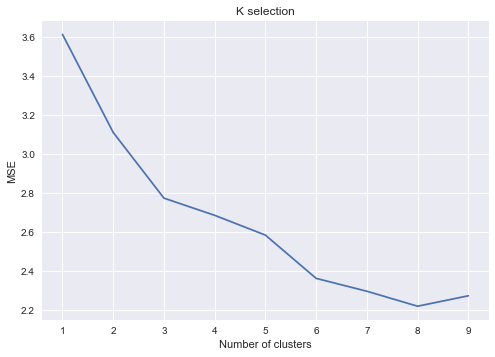

In [50]:
# Finding best k
plt.style.use("seaborn")
Ks = 10
mse = np.zeros((Ks-1))
tony_grouped_clustering = tony_grouped.drop(['Neighborhood','Borough','Neighborhood Latitude','Neighborhood Longitude'], 1)
for n in range(1,Ks):
    
    # set number of clusters
    kclusters = n
    # run k-means clustering
    kmeans = KMeans(n_clusters=kclusters, random_state=0, init = 'random', n_init = 15).fit(tony_grouped_clustering)
    mse[n-1] = kmeans.inertia_

plt.plot(range(1,Ks),mse)
plt.xlabel("Number of clusters")
plt.ylabel("MSE")
plt.title("K selection")
plt.show()


In [51]:
# set number of clusters
kclusters = 5
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0, init = 'random', n_init = 15).fit(tony_grouped_clustering)
    
tony_merged = df

# add clustering labels
tony_merged['Cluster Labels'] = kmeans.labels_

tony_merged

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels
0,Manhattan,Marble Hill,40.876551,-73.910660,4
1,Manhattan,Chinatown,40.715618,-73.994279,4
2,Manhattan,Washington Heights,40.851903,-73.936900,4
...,...,...,...,...,...
75,Downtown Toronto,"First Canadian Place, Underground city",43.648429,-79.382280,4
76,Downtown Toronto,Church and Wellesley,43.665860,-79.383160,4
77,East Toronto,Business Reply Mail Processing Centre 969 Eastern,43.662744,-79.321558,4


### 4.2 Displaying Clusters

In [54]:
map_clusters = folium.Map(location=[centerLatitude, centerLongitude], zoom_start=7, width='100%', height='100%')

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(tony_merged['Latitude'], tony_merged['Longitude'], tony_merged['Neighborhood'], tony_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [53]:

# create map
map_clusters = folium.Map(location=[ny_latitude, ny_longitude], zoom_start=11, width='100%', height='100%')

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(tony_merged['Latitude'], tony_merged['Longitude'], tony_merged['Neighborhood'], tony_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       


minimap = MiniMap(position = 'topleft', center_fixed = (ny_latitude, ny_longitude), zoom_level_fixed = 8)
minimap.add_to(map_clusters)

minimap = MiniMap(position='bottomright',  center_fixed = (to_latitude, to_longitude), zoom_level_fixed = 8)
minimap.add_to(map_clusters)
map_clusters

In [55]:
map_clusters = folium.Map(location=[to_latitude, to_longitude], zoom_start=11, width='100%', height='100%')

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(tony_merged['Latitude'], tony_merged['Longitude'], tony_merged['Neighborhood'], tony_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       


minimap = MiniMap(position = 'topleft', center_fixed = (ny_latitude, ny_longitude), zoom_level_fixed = 8)
minimap.add_to(map_clusters)

minimap = MiniMap(position='bottomright',  center_fixed = (to_latitude, to_longitude), zoom_level_fixed = 8)
minimap.add_to(map_clusters)
map_clusters

### 4.3 Analysing Centroids

* Cluster 1

In [60]:

cl1 = tony_merged.loc[tony_merged['Cluster Labels'] == 0, tony_merged.columns[[1] + list(range(5, tony_merged.shape[1]))]]
cl1

,Neighborhood
28,Battery Park City
38,Flatiron
49,"Harbourfront East, Toronto Islands, Union Station"
56,Studio District


* Cluster 2

In [62]:
cl2 = tony_merged.loc[tony_merged['Cluster Labels'] == 1, tony_merged.columns[[1] + list(range(5, tony_merged.shape[1]))]]
cl2

,Neighborhood
5,Manhattanville
22,Little Italy
35,Turtle Bay
...,...
54,"The Beaches West, India Bazaar"
64,"Parkdale, Roncesvalles"
67,"Runnymede, Swansea"


* Cluster 3

In [63]:
pd.set_option('max_rows', 100)
cl3 = tony_merged.loc[tony_merged['Cluster Labels'] == 2, tony_merged.columns[[1] + list(range(5, tony_merged.shape[1]))]]
cl3

,Neighborhood
57,Lawrence Park


* Cluster 4

In [64]:

cl4 = tony_merged.loc[tony_merged['Cluster Labels'] == 3, tony_merged.columns[[1] + list(range(5, tony_merged.shape[1]))]]
cl4

,Neighborhood
19,East Village


* Cluster 5

In [65]:
cl5 = tony_merged.loc[tony_merged['Cluster Labels'] == 4, tony_merged.columns[[1] + list(range(5, tony_merged.shape[1]))]]
cl5

,Neighborhood
0,Marble Hill
1,Chinatown
2,Washington Heights
3,Inwood
4,Hamilton Heights
6,Central Harlem
7,East Harlem
8,Upper East Side
9,Yorkville
10,Lenox Hill


### 5. Data Visualisation

#### 5.1 Bar Chart

In [67]:
tmp = np.zeros((kmeans.cluster_centers_.shape))
tmp[0,:] = kmeans.cluster_centers_[4,:]
tmp[1,:] = kmeans.cluster_centers_[0,:]
tmp[2,:] = kmeans.cluster_centers_[3,:]
tmp[3,:] = kmeans.cluster_centers_[1,:]
tmp[4,:] = kmeans.cluster_centers_[2,:]
maxi = []
for i in range(5):
    maxi.extend(tmp[i,:].argsort()[-3:][::-1])
    
args = np.asarray(list(set(maxi)))
table = pd.DataFrame(data = tmp[:,args.astype(int)], index = ['Cluster I', 'Cluster II', 'Cluster III', 'Cluster IV','Cluster V'], columns = tony_grouped_clustering.columns[args.astype(int)])
table = table.transpose()

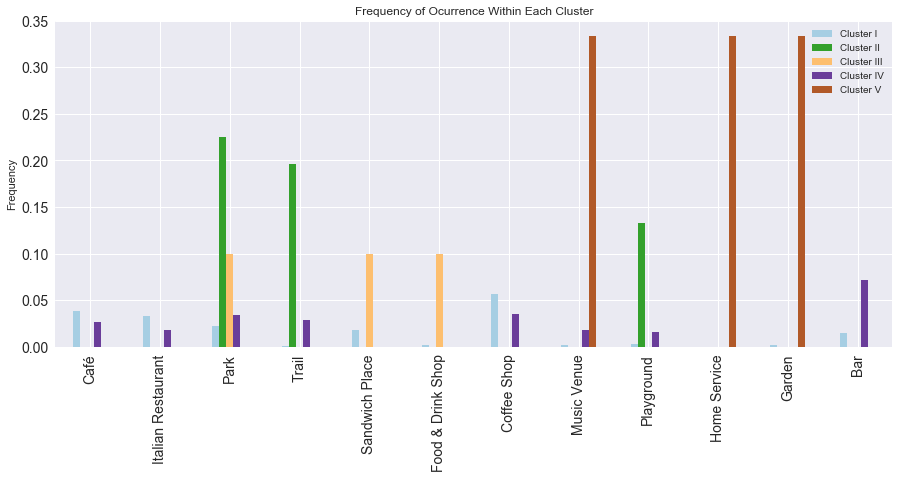

In [68]:
plt.style.use('seaborn')
ax = table.plot(kind='bar', figsize=(15,6), rot=90, fontsize = 14, colormap = 'Paired')
bars = ax.get_children()
plt.title("Frequency of Ocurrence Within Each Cluster")
plt.ylabel("Frequency")

plt.show()

In [69]:
maxi = []
for i in range(5):
    maxi.extend(tmp[i,:].argsort()[-3:][::-1])
    
args = np.asarray(list(set(maxi)))
table = pd.DataFrame(data = tmp[:,args.astype(int)], index = ['Cluster I', 'Cluster II', 'Cluster III', 'Cluster IV','Cluster V'], columns = tony_grouped_clustering.columns[args.astype(int)])
table = table.T
table.drop(["Garden"], inplace= True)

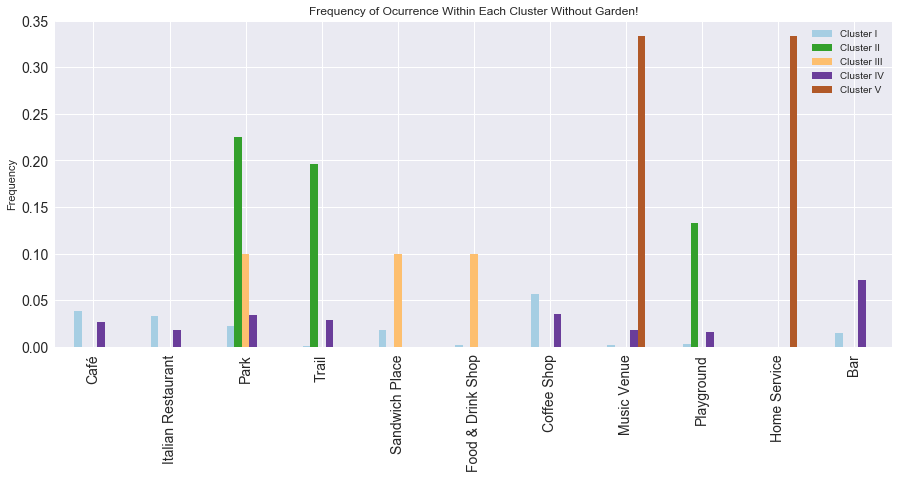

In [70]:

plt.style.use('seaborn')
ax = table.plot(kind='bar', figsize=(15,6), rot=90, fontsize = 14, colormap = "Paired")
bars = ax.get_children()
plt.title("Frequency of Ocurrence Within Each Cluster Without Garden!")
plt.ylabel("Frequency")
plt.show()

#### 5.2 Word Cloud

In [72]:
word_string = ""
for neighborhood in tony_merged["Neighborhood"]:
    elements = ""
    for element in neighborhood.split(","):
        elements += element.strip().replace(" ", "") + " "
    word_string += elements+" "
word_string = word_string.replace(".","")

tmp = cl1["Neighborhood"].tolist()
cl1_list = []
for element in tmp:
    cl1_list.extend(element.split(", "))
cl1_list = [element.replace(" ","") for element in cl1_list]

tmp = cl2["Neighborhood"].tolist()
cl2_list = []
for element in tmp:
    cl2_list.extend(element.split(", "))
cl2_list = [element.replace(" ","") for element in cl2_list]
    
tmp = cl3["Neighborhood"].tolist()
cl3_list = []
for element in tmp:
    cl3_list.extend(element.split(", "))
cl3_list = [element.replace(" ","") for element in cl3_list]
cl3_list = [element.replace(".","") for element in cl3_list]

tmp = cl4["Neighborhood"].tolist()
cl4_list = []
for element in tmp:
    cl4_list.extend(element.split(", "))
cl4_list = [element.replace(" ","") for element in cl4_list]    

tmp = cl5["Neighborhood"].tolist()
cl5_list = []
for element in tmp:
    cl5_list.extend(element.split(", "))
cl5_list = [element.replace(" ","") for element in cl5_list]

cl1_list

['BatteryParkCity',
 'Flatiron',
 'HarbourfrontEast',
 'TorontoIslands',
 'UnionStation',
 'StudioDistrict']

Word cloud created!


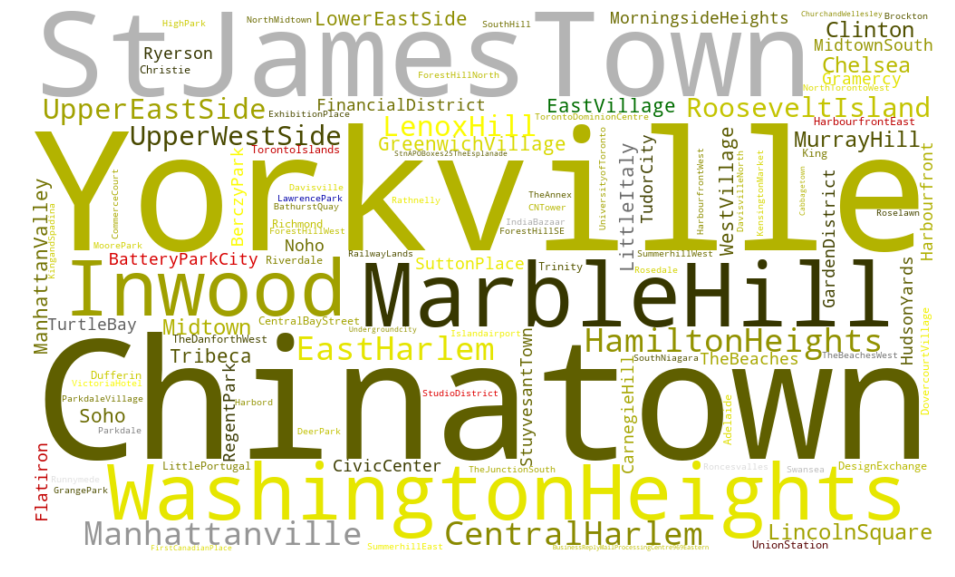

In [73]:
class GroupedColorFunc(object):
    """Create a color function object which assigns DIFFERENT SHADES of
       specified colors to certain words based on the color to words mapping.

       Uses wordcloud.get_single_color_func

       Parameters
       ----------
       color_to_words : dict(str -> list(str))
         A dictionary that maps a color to the list of words.

       default_color : str
         Color that will be assigned to a word that's not a member
         of any value from color_to_words.
    """

    def __init__(self, color_to_words, default_color):
        self.color_func_to_words = [
            (get_single_color_func(color), set(words))
            for (color, words) in color_to_words.items()]

        self.default_color_func = get_single_color_func(default_color)

    def get_color_func(self, word):
        """Returns a single_color_func associated with the word"""
        try:
            color_func = next(
                color_func for (color_func, words) in self.color_func_to_words
                if word in words)
        except StopIteration:
            color_func = self.default_color_func

        return color_func

    def __call__(self, word, **kwargs):
        return self.get_color_func(word)(word, **kwargs)

wordcloud = WordCloud(width=1000, height=600, background_color='white', max_words = 500).generate(word_string)

color_to_words = {
    # words below will be colored with a green single color function
    '#FF0000': cl1_list,
    # will be colored with a red single color function
    'black': cl2_list,
    'blue': cl3_list,
    '#00ff00': cl4_list,
    'yellow': cl5_list
}

default_color = 'grey'

print('Word cloud created!')

fig = plt.figure()
fig.set_figwidth(500)
fig.set_figheight(10)

grouped_color_func = GroupedColorFunc(color_to_words, default_color)

# Apply our color function
wordcloud.recolor(color_func=grouped_color_func)

plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

#### 5.3 Waffle Chart

In [75]:
def create_waffle_chart(categories, values, height, width, colormap, value_sign=''):

    # compute the proportion of each category with respect to the total
    total_values = sum(values)
    category_proportions = [(float(value) / total_values) for value in values]

    # compute the total number of tiles
    total_num_tiles = width * height # total number of tiles
    print ('Total number of tiles is', total_num_tiles)
    
    # compute the number of tiles for each catagory
    tiles_per_category = [round(proportion * total_num_tiles) for proportion in category_proportions]

    # print out number of tiles per category
    for i, tiles in enumerate(tiles_per_category):
        print (categories[i] + ': ' + str(tiles))
    
    # initialize the waffle chart as an empty matrix
    waffle_chart = np.zeros((height, width))

    # define indices to loop through waffle chart
    category_index = 0
    tile_index = 0

    # populate the waffle chart
    for col in range(width):
        for row in range(height):
            tile_index += 1

            # if the number of tiles populated for the current category 
            # is equal to its corresponding allocated tiles...
            if tile_index > sum(tiles_per_category[0:category_index]):
                # ...proceed to the next category
                category_index += 1       
            
            # set the class value to an integer, which increases with class
            waffle_chart[row, col] = category_index
    
    # instantiate a new figure object
    fig = plt.figure()

    # use matshow to display the waffle chart
    plt.matshow(waffle_chart, cmap=colormap)
    plt.colorbar()

    # get the axis
    ax = plt.gca()

    # set minor ticks
    ax.set_xticks(np.arange(-.5, (width), 1), minor=True)
    ax.set_yticks(np.arange(-.5, (height), 1), minor=True)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    # add dridlines based on minor ticks
    ax.grid(which='minor', color='w', linestyle='-', linewidth=2)

    plt.xticks([])
    plt.yticks([])

    # compute cumulative sum of individual categories to match color schemes between chart and legend
    values_cumsum = np.cumsum(values)
    total_values = values_cumsum[len(values_cumsum) - 1]
    #print(values_cumsum)

    # create legend
    legend_handles = []
    for i, category in enumerate(categories):
        if value_sign == '%':
            label_str = category + ' (' + str(values[i]) + value_sign + ')'
        else:
            label_str = category + ' (' + value_sign + str(values[i]) + ')'
            
        #color_val = colormap((float(values_cumsum[i])/total_values))
        color_val = colormap(np.linspace(0,1,5)[i])
        #print(np.arange(1,6)[i]/5)
        legend_handles.append(mpatches.Patch(color=color_val, label=label_str))

    # add legend to chart
    plt.legend(
        handles=legend_handles,
        loc='lower center', 
        ncol=len(categories),
        bbox_to_anchor=(0., -0.2, 0.95, .1)
    )

Total number of tiles is 400
Cluster I: 333
Cluster II: 21
Cluster III: 5
Cluster IV: 36
Cluster V: 5


<Figure size 576x396 with 0 Axes>

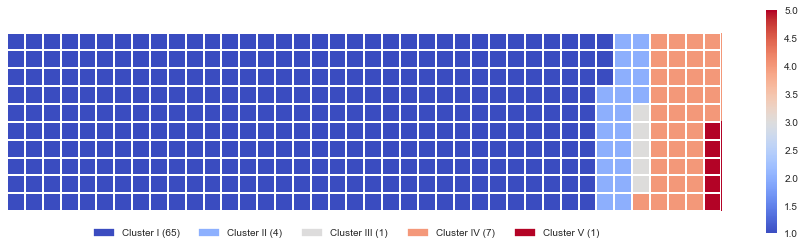

In [76]:
index = ['Cluster I', 'Cluster II', 'Cluster III', 'Cluster IV','Cluster V']
portions = [cl5.shape[0], cl1.shape[0], cl4.shape[0], cl2.shape[0], cl3.shape[0]]
width = 40 # width of chart
height = 10 # height of chart

categories = index # categories
values = portions # correponding values of categories

colormap = plt.cm.coolwarm# color map class
create_waffle_chart(categories, values, height, width, colormap)